In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report
import wandb
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
import mambapy
from mambapy.mamba import Mamba, MambaConfig
from torch import nn, optim


In [ ]:
class BalancedDataset(Dataset):
    def __init__(self, X, y, limit_per_label=1600):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]
# Custom Dataset for validation with limit per class
class BalancedValidationDataset(Dataset):
    def __init__(self, X, y, limit_per_label=400):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]
    
def train_model_mamba(
    model, train_loader, val_loader, test_loader, 
    num_epochs=500, lr=1e-4, max_patience=20, device='cuda'
):
    # Move model to device
    model = model.to(device)

    # Define optimizer, scheduler, and loss function
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=int(max_patience / 3), verbose=True
    )

    criterion = nn.BCELoss()

    best_val_loss = float('inf')
    patience = max_patience

    for epoch in range(num_epochs):
        # Resample training and validation data
        train_loader.dataset.re_sample()
        val_loader.dataset.balance_classes()

        # Training phase
        model.train()
        train_loss, train_accuracy = 0.0, 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_accuracy += (outputs.argmax(dim=1) == y_batch).float().mean().item()

        # Validation phase
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)

                val_loss += loss.item() * X_val.size(0)
                val_accuracy += (outputs.argmax(dim=1) == y_val).float().mean().item()

        # Test phase and metric collection
        test_loss, test_accuracy = 0.0, 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                outputs = model(X_test)
                loss = criterion(outputs, y_test)

                test_loss += loss.item() * X_test.size(0)
                test_accuracy += (outputs.argmax(dim=1) == y_test).float().mean().item()
                y_true.extend(y_test.cpu().numpy())
                y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

        # Update scheduler
        scheduler.step(val_loss / len(val_loader.dataset))

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss / len(train_loader.dataset),
            "val_loss": val_loss / len(val_loader.dataset),
            "train_accuracy": train_accuracy / len(train_loader),
            "val_accuracy": val_accuracy / len(val_loader),
            "learning_rate": optimizer.param_groups[0]['lr'],
            "test_loss": test_loss / len(test_loader.dataset),
            "test_accuracy": test_accuracy / len(test_loader),
            "confusion_matrix": wandb.plot.confusion_matrix(
                probs=None, y_true=y_true, preds=y_pred, class_names=np.unique(y_true)
            ),
            "classification_report": classification_report(
                y_true, y_pred, target_names=[str(i) for i in range(len(np.unique(y_true)))]
            )
        })

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = max_patience
            best_model = model.state_dict()
        else:
            patience -= 1
            if patience <= 0:
                print("Early stopping triggered.")
                break

    # Load the best model weights
    model.load_state_dict(best_model)
    return model



In [6]:
# Open the list of classes dataframe
classes = np.load("Pickles/List_of_Classes.pkl", allow_pickle=True)

In [7]:
X = pd.read_pickle("Pickles/train_data_transformed.pkl")
y = X[classes]

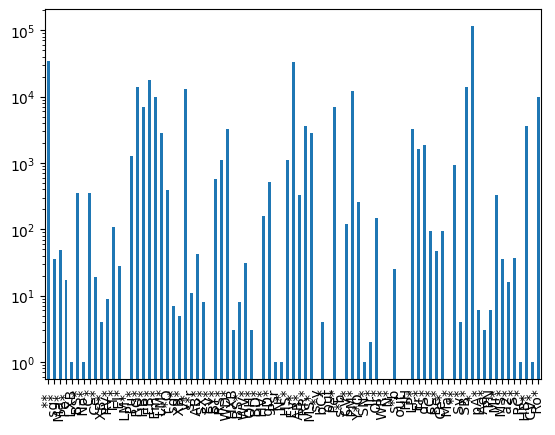

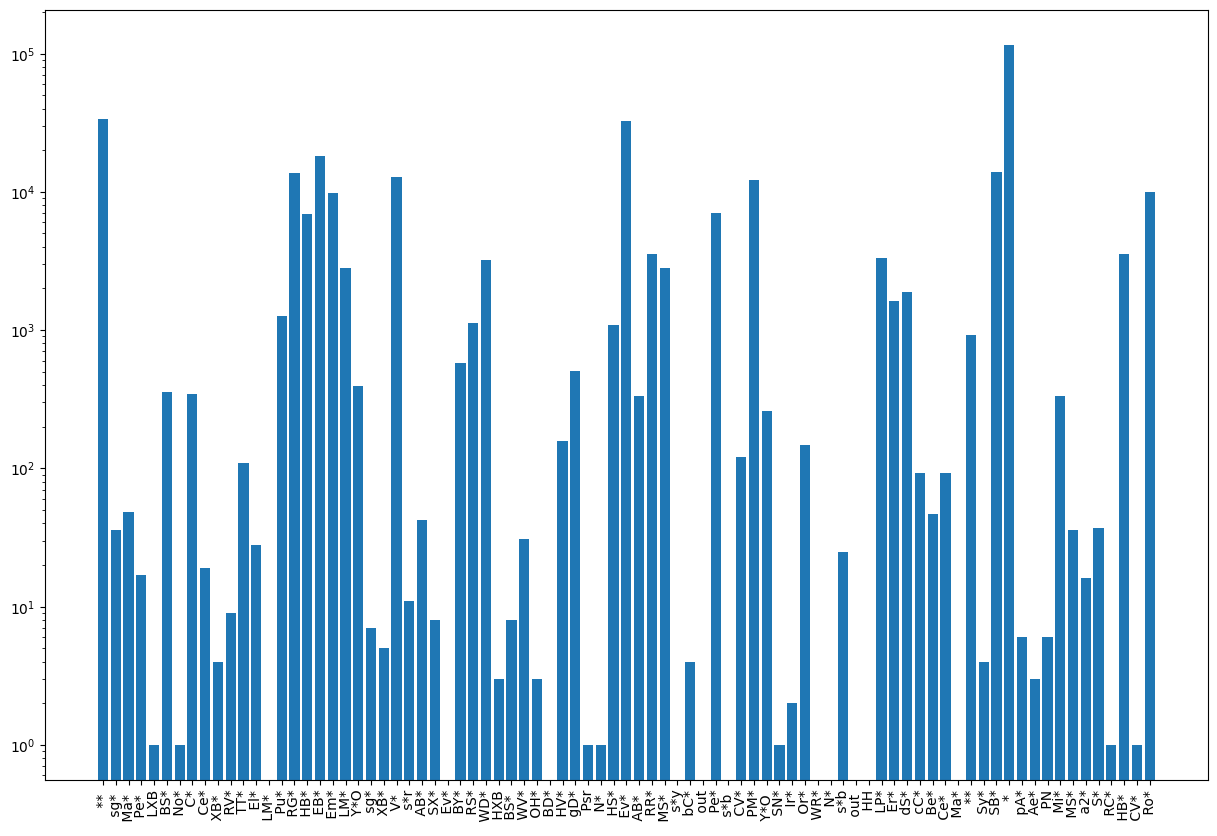

In [11]:
# Plot the distribution of the classes log scaled
y.sum().plot(kind='bar', logy=True)

# MAke the plot larger and pretty
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.bar(y.columns, y.sum(), log=True)
plt.xticks(rotation=90)
plt.show()


In [ ]:
batch_size = 256

# Example usage
if __name__ == "__main__":
    # Load and preprocess your data (example from original script)
    # Load and preprocess data
    X = pd.read_pickle("Pickles/train_data_transformed.pkl")
    y = X[classes]
    label_mapping = {'star': 0, 'binary_star': 1, 'galaxy': 2, 'agn': 3}
    y = y.map(label_mapping).values
    X = X.drop(["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
                "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
                "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", "label", "obsid"], axis=1).values
    
    # Read test data
    X_test = pd.read_pickle("Pickles/testv2.pkl")
    y_test = X_test["label"].map(label_mapping).values
    X_test = X_test.drop(["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
                "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
                "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", "label", "obsid"], axis=1).values
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Clear memory
    del X, y
    gc.collect()

    # Convert to torch tensors and create datasets
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)

    train_dataset = BalancedDataset(X_train, y_train)
    val_dataset = BalancedValidationDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(BalancedValidationDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(1),
                                                    torch.tensor(y_test, dtype=torch.long)), batch_size=batch_size, shuffle=False)
    


In [ ]:
class StarClassifierMAMBA(nn.Module):
    def __init__(self, d_model, num_classes, d_state=64, d_conv=4, input_dim=17, n_layers=6):
        super(StarClassifierMAMBA, self).__init__()
        self.d_model = d_model
        self.num_classes = num_classes

        # MAMBA layer initialization
        config = MambaConfig(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            n_layers=n_layers

        )
        self.mamba_layer = Mamba(config)

        # Input projection to match the MAMBA layer dimension
        self.input_projection = nn.Linear(input_dim, d_model)

        # Fully connected classifier head with sigmoid activation for multi-label classification
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.input_projection(x)  # Ensure the input has the correct dimension
        #x = x.unsqueeze(1)  # Adds a sequence dimension (L=1).
        x = self.mamba_layer(x)
        x = x.mean(dim=1)  # Pooling operation for classification
        x = self.classifier(x)
        return x

In [ ]:
# Define the model with your parameters
d_model = 2048 # Embedding dimension
num_classes = 4  # Star classification categories

# Define the training parameters
num_epochs = 500
lr = 2e-7
patience = 50   
depth = 6

# Define the config dictionary object
config = {"num_classes": num_classes, "batch_size": batch_size, "lr": lr, "patience": patience, "num_epochs": num_epochs, "d_model": d_model, "depth": depth}

# Initialize WandB project
wandb.init(project="lamost-mamba-test", entity="joaoc-university-of-southampton", config=config)
# Initialize and train the model
# Train the model using your `train_model_vit` or an adjusted training loop
model_mamba = StarClassifierMAMBA(d_model=d_model, num_classes=num_classes, input_dim=3748, n_layers=depth)
print(model_mamba)
# print number of parameters per layer
for name, param in model_mamba.named_parameters():
    print(name, param.numel())
print("Total number of parameters:", sum(p.numel() for p in model_mamba.parameters() if p.requires_grad))

# Move the model to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_mamba = model_mamba.to(device)

# Train the model using your `train_model_vit` or an adjusted training loop
trained_model = train_model_mamba(
    model=model_mamba,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=num_epochs,
    lr=lr,
    max_patience=patience,
    device=device
)
# Save the model and finish WandB session
wandb.finish()